In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

! pip install -q scikeras
from scikeras.wrappers import KerasRegressor

import pickle

In [2]:
df = pd.read_csv('Indian ATM preprocessed.csv')

In [3]:
X, y = df.iloc[:, :32], df.iloc[:, 32]

tr = int(len(X) * 0.8)
ts = int(len(X) * 0.9)
X_train, y_train = X[:tr], y[:tr]
X_val, y_val = X[tr:ts], y[tr:ts]
X_test, y_test = X[ts:], y[ts:]


In [4]:

def train_models(X_train, X_test, y_train, y_test, models, params, cv=3, n_jobs=3, verbose=0, refit=False):

    results_df = pd.DataFrame({
        'Name': [], 'R2 Score': [],
        'MAE': [],  'MSE': [],
        'MAPE': [], 'SMAPE': [],
    })

    m = []

    for i in range(len(models)):

        model=list(models.values())[i]
        para=params[list(models.keys())[i]]

        gs = GridSearchCV(model, para, cv = cv, n_jobs = n_jobs, verbose = verbose,refit = refit, scoring = 'neg_mean_absolute_error')
        gs.fit(X_train,y_train)

        model.set_params(**gs.best_params_)
        model.fit(X_train,y_train)

        y_pred = model.predict(X_test)
        result = get_results(y_test, y_pred, name = list(models.keys())[i])
        results_df = pd.concat([results_df, result], axis = 0)
        m.append(model)

    results_df = results_df.dropna()
    return results_df, m


def calculate_smape(actual, predicted):

    if len(actual.shape) > 0:
      actual = np.array(actual).flatten()

    if len(predicted.shape) > 0:
      predicted = np.array(predicted).flatten()

    absolute_diff = np.abs(actual - predicted)
    sum_absolute = np.abs(actual) + np.abs(predicted)

    # Avoid division by zero
    mask = sum_absolute != 0
    smape = np.mean(200 * (absolute_diff[mask] / sum_absolute[mask]))

    return smape


def get_results(y_test, y_pred, name=''):

    score = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    smape = calculate_smape(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results = pd.DataFrame({
        'Name': [name], 'R2 Score': [score],
        'MAE': [mae],   'MSE': [mse],
        'MAPE': [mape],  'SMAPE': [smape]
    })

    return results


In [5]:

from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import xgboost as xgb


models = {
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(alpha = 0.001, tol = 0.001),
    'KNN Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Light GBM': lgb.LGBMRegressor(verbosity=-1),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'SGD Regressor': SGDRegressor()
}

params = {
    'Linear Regression': {},
    'Light GBM': {},
    'Elastic Net': {
        'alpha'     : [0.1, 1, 10, 0.01],
        'tol'       : [0.0001, 0.001, 0.01]
    },
    'KNN Regressor': {
        'n_neighbors' : [3,5,7,9],
    },
    'Random Forest Regressor': {
        'n_estimators': [100, 150, 200, 250],
        'max_depth': [5,7,9,11]
    },
    'Gradient Boosting Regressor': {
        'learning_rate':[0.1,.01,.05],
        'n_estimators': [100, 150, 200],
        'max_depth': [5,7,9,]
    },
    'SGD Regressor': {
        'penalty': ['l2', 'elasticnet'],
        'alpha': [0.01, 0.001, 0.0001]
    }

}


In [6]:

from scipy.stats import t

def get_range(X_train, X_test, y_train, y_test, mod):

    mod.fit(X_train, y_train)

    train_pred = mod.predict(X_train).ravel()
    test_pred = mod.predict(X_test).ravel()

    # Calculate residuals and standard deviation of residuals
    residuals = y_train - train_pred
    s = np.sqrt(np.sum(residuals**2) / (len(y_train) - 2))

    # Calculate mean and sum of squared differences from the mean for X
    X_mean = np.mean(X_train)
    sum_squared_diffs = np.sum((X_train - X_mean)**2)

    # Define confidence level
    confidence_level = 0.95
    t_score = t.ppf(1 - (1 - confidence_level) / 2, df=len(X_train) - 2)

    # Prediction interval for each prediction in y_pred
    cnt = 0
    intervals = []
    for x, pred in zip(X_test, test_pred):
        interval_margin = t_score * s * np.sqrt(1 + (1/len(X_train)) + ((x - X_mean)**2 / sum_squared_diffs))
        lower_bound = pred - interval_margin
        upper_bound = pred + interval_margin
        upper_bound = upper_bound.min()
        lower_bound = np.max([lower_bound.max(), upper_bound / 4])
        intervals.append((lower_bound, upper_bound))

    intervals = np.array(intervals)

    lower = intervals[:, 0]
    upper = intervals[:, 1]
    avg = (lower + upper) / 2

    c1 = lower < y_test
    c2 = y_test < upper

    c = (c1 & c2).apply(lambda x: 0 if x == True else 1)

    range = pd.DataFrame({
        'lower': lower,
        'original': y_test,
        'predicted': test_pred,
        'upper': upper,
        'error': test_pred - y_test,
        'outcome': c
    })

    return range


def plot_range(range):

    plt.figure(figsize = (20,7))

    r = range[:360]
    sns.lineplot(data = r, x = 'Transaction Date', y = 'original', label = 'original')
    sns.lineplot(data = r, x = 'Transaction Date', y = 'lower', label = 'lower')
    sns.lineplot(data = r, x = 'Transaction Date', y = 'upper', label = 'upper')
    plt.legend()
    plt.xlabel('Transaction Date')
    plt.ylabel('Transaction Amount')
    plt.title('Range Prediction')
    plt.show()
    print()


In [ ]:
# running models
results_df, models = train_models(X_train, X_val, y_train, y_val, models, params)

In [ ]:
results_df['Model'] = models
results_df = results_df.sort_values(by = ['R2 Score', 'MAE'], ascending = [False, True]).reset_index(drop = True)
results_df = np.round(results_df, 4)
results_df.to_csv('Model Result.csv', index=False)
results_df

,Name,R2 Score,MAE,MSE,MAPE,SMAPE,Model
0,Gradient Boosting Regressor,0.9704,27643.5641,1.637153e+09,0.6235,15.3494,([DecisionTreeRegressor(criterion='friedman_ms...
1,Light GBM,0.9691,28155.5478,1.708370e+09,0.9722,16.4443,LGBMRegressor(verbosity=-1)
2,Linear Regression,0.9686,29808.2484,1.736856e+09,1.2986,23.9129,LinearRegression()
3,Elastic Net,0.9664,30218.4070,1.857373e+09,1.1365,22.5847,"ElasticNet(alpha=0.01, tol=0.01)"
4,SGD Regressor,0.9638,30976.8866,2.001996e+09,1.0924,22.1281,SGDRegressor(alpha=0.01)
5,Random Forest Regressor,0.9623,30238.4638,2.084854e+09,0.2328,14.2316,"(DecisionTreeRegressor(max_depth=11, max_featu..."
6,KNN Regressor,0.8944,56740.9626,5.839666e+09,6.1825,30.1948,KNeighborsRegressor(n_neighbors=9)


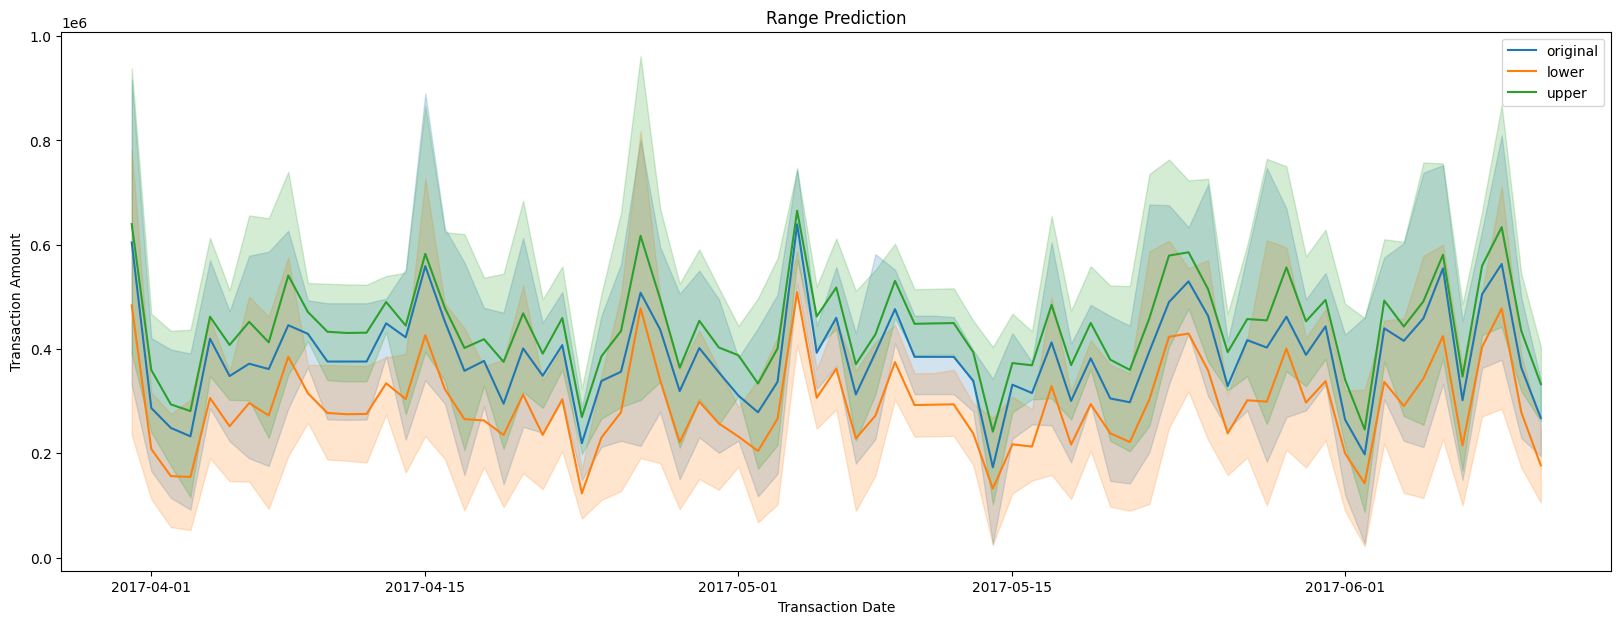

,proportion
outcome,
0,91.876972
1,8.123028


In [ ]:

m = []

for i in results_df['Model']:
    range = get_range(X_train, X_test, y_train, y_test, i)
    x = range['outcome'].value_counts(normalize = True)[1]
    m.append(x)

m = np.array(m)
min = np.argmin(m)
model = results_df.loc[min, 'Model']
model = LinearRegression()
# model = results_df.loc[0, 'Model']

range = get_range(X_train, X_test, y_train, y_test, model)

ind = range.index
range['Transaction Date'] = df.loc[ind, 'Transaction Date']

plot_range(range)
range['outcome'].value_counts(normalize = True) * 100



In [ ]:
def run_ann(X_train, X_test, y_train, y_test):

    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="linear"),
    ])

    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), verbose = 0, batch_size = 32)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    return train_pred, test_pred, model


# training ANN

train_pred, test_pred, model = run_ann(X_train, X_val, y_train, y_val)


317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
result_ann = get_results( y_val, test_pred, 'ANN')
result_ann['Model'] = model
results_df = pd.concat([results_df, result_ann], axis = 0)

results_df = results_df.sort_values(by = [ 'R2 Score', 'MAE'], ascending = [ False, True]).reset_index(drop = True)
results_df = np.round(results_df, 4)
results_df


,Name,R2 Score,MAE,MSE,MAPE,SMAPE,Model
0,ANN,0.9755,25911.9920,1.353122e+09,2.1206,17.9838,"<Sequential name=sequential, built=True>"
1,Gradient Boosting Regressor,0.9704,27643.5641,1.637153e+09,0.6235,15.3494,([DecisionTreeRegressor(criterion='friedman_ms...
2,Light GBM,0.9691,28155.5478,1.708370e+09,0.9722,16.4443,LGBMRegressor(verbosity=-1)
3,Linear Regression,0.9686,29808.2484,1.736856e+09,1.2986,23.9129,LinearRegression()
4,Elastic Net,0.9664,30218.4070,1.857373e+09,1.1365,22.5847,"ElasticNet(alpha=0.01, tol=0.01)"
5,SGD Regressor,0.9638,30976.8866,2.001996e+09,1.0924,22.1281,SGDRegressor(alpha=0.01)
6,Random Forest Regressor,0.9623,30238.4638,2.084854e+09,0.2328,14.2316,"(DecisionTreeRegressor(max_depth=11, max_featu..."
7,KNN Regressor,0.8944,56740.9626,5.839666e+09,6.1825,30.1948,KNeighborsRegressor(n_neighbors=9)


317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 25741.1562 - mae: 25741.1562
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


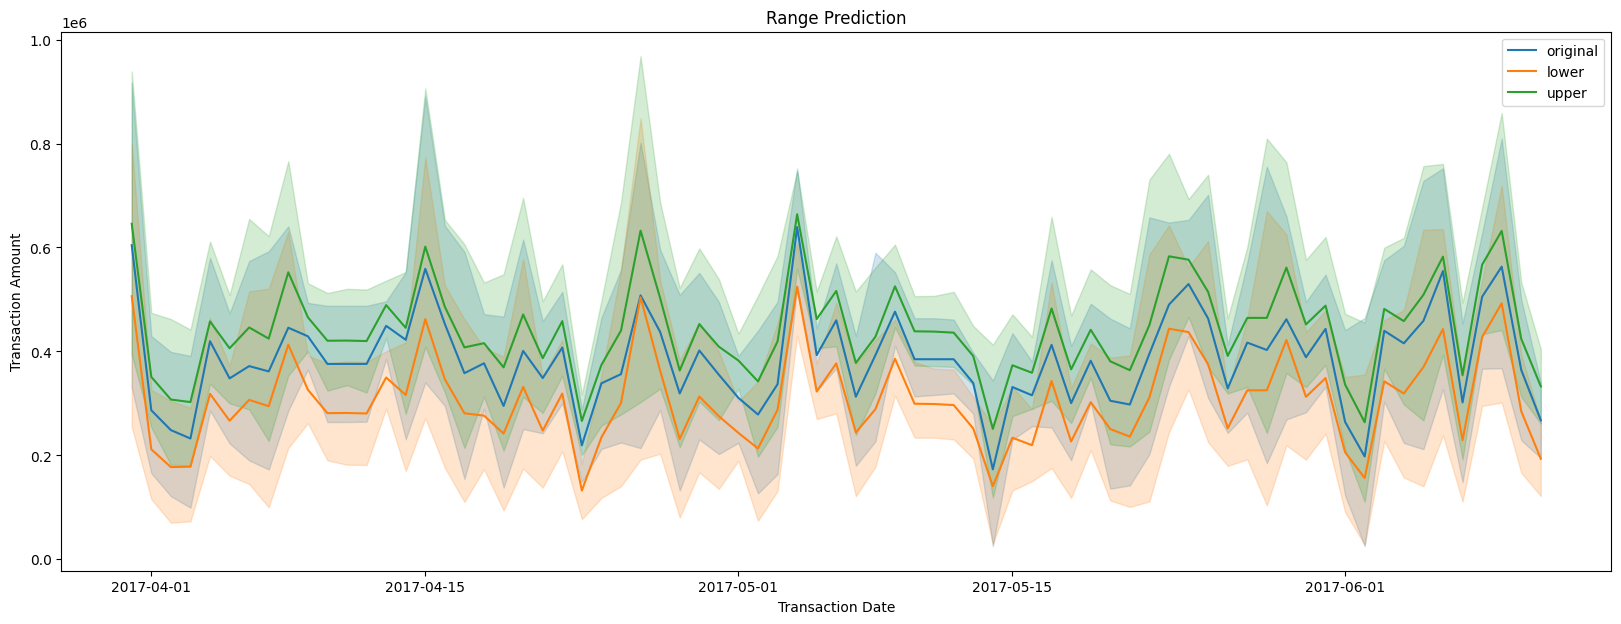

,proportion
outcome,
0,90.930599
1,9.069401


In [ ]:
range = get_range(X_train, X_test, y_train, y_test, model)

ind = range.index
range['Transaction Date'] = df.loc[ind, 'Transaction Date']

plot_range(range)
range['outcome'].value_counts(normalize = True) * 100


In [7]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):

    X, y = list(), list()

    i = 0

    while i < len(sequence):

        # find the end of this pattern
        end_ix = i + n_steps

        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
          break

        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

        i += 1

    return array(X), array(y)


In [8]:
y_mean = np.mean(y_train)
y_std = np.std(y_train)

y_test_normalized = (y_test - y_mean) / y_std
y_train_normalized = (y_train - y_mean) / y_std

In [68]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# define input sequence
raw_seq_train = np.array(y_train_normalized)
raw_seq_test = np.array(y_test_normalized)

n_steps = 15
n_features = 1

In [74]:

# split into samples
X_train_seq, y_train_seq = split_sequence(raw_seq_train, n_steps)
X_test_seq, y_test_seq = split_sequence(raw_seq_test, n_steps)

X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], n_features))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], n_steps, n_features))


# # define model
model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape = (n_steps, n_features)),
        LSTM(64, activation='relu', return_sequences=True, ),
        Dense(1, activation='linear')
        ])

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mae')



In [75]:
# fit model
model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, verbose=0, validation_data=(X_test_seq, y_test_seq))

In [76]:
model.save('LSTM.keras')
with open('LSTM.pkl', 'wb') as file:
    pickle.dump(model, file)

In [77]:
pred = model.predict(X_test_seq, verbose=0)
pred = np.mean(pred, axis=1)[:, 0]
pred_denorm = pred * y_std + y_mean

result_lstm = get_results( y_test[n_steps:], pred_denorm, 'LSTM')
result_lstm

,Name,R2 Score,MAE,MSE,MAPE,SMAPE
0,LSTM,-0.257176,173322.824646,4.730098e+10,7.594762,44.40858
